In [1]:
!pip install pytorch_forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.2/812.2 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [2]:
# from pytorch_forecasting.models.nbeats import NBeats
from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE
from pytorch_forecasting.data.encoders import NaNLabelEncoder
import pandas as pd
import numpy as np
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [3]:
# Đọc dữ liệu
data = pd.read_csv('VRTX_processed.csv')
# Convert 'Date' to datetime và sort
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

# Giữ lại bản sao của cột ngày gốc
original_dates = data['Date'].copy()

# Chuyển đổi ngày thành chỉ số số nguyên
data['Date'] = np.arange(0, data.shape[0])
data['series'] = 0  # single series

In [4]:
# Parameters
max_encoder_length = 180
def prepare_data(data, split_ratio, max_encoder_length):
  # Split data into train and test sets based on a 80/20 ratio
  train_size = int(len(data) * split_ratio)

  train_data = data.iloc[:train_size]
  test_data = data.iloc[train_size - max_encoder_length:]  # Include overlap for encoder length
  return train_data, test_data, train_size

In [5]:
# Load the best model
def train_nbeats_model(train_data, test_data, max_prediction_length, train_size, max_encoder_length):
  # Create TimeSeriesDataSet for training
  training = TimeSeriesDataSet(
      train_data,
      time_idx="Date",
      target="Adj Close",
      categorical_encoders={"series": NaNLabelEncoder().fit(train_data.series)},
      group_ids=["series"],
      time_varying_unknown_reals=["Adj Close"],
      max_encoder_length=max_encoder_length,
      max_prediction_length=max_prediction_length,
  )

  # Create TimeSeriesDataSet for testing
  testing = TimeSeriesDataSet.from_dataset(training, test_data, min_prediction_idx=train_size)

  # DataLoader
  batch_size = 32
  train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=3)
  test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size, num_workers=3)

  # Trainer setup
  early_stop_callback = EarlyStopping(monitor="train_loss_epoch", min_delta=1e-4, patience=10, verbose=False, mode="min")
  trainer = pl.Trainer(
      max_epochs=30,
      accelerator="auto",
      enable_model_summary=True,
      gradient_clip_val=0.01,
      log_every_n_steps=10,
      limit_train_batches=150,
      callbacks=[early_stop_callback]
  )

  # Initialize NBeats model
  net = NBeats.from_dataset(
      training,
      learning_rate=1e-3,
      log_interval=10,
      log_val_interval=1,
      weight_decay=1e-2,
      widths=[32, 512],
      backcast_loss_ratio=1.0,
  )

  # Train the model
  trainer.fit(
      net,
      train_dataloaders=train_dataloader,
  )

  # Load the best model
  best_model_path = trainer.checkpoint_callback.best_model_path
  best_model = NBeats.load_from_checkpoint(best_model_path)
  return best_model, test_dataloader, training



In [6]:
def evaluate_model(best_model, test_data, test_dataloader, max_prediction_length, train_size):
  # Make predictions on the test set
  predictions = best_model.predict(test_dataloader)

  # Extract true values for comparison
  true_values = test_data.loc[test_data['Date'] >= train_size, 'Adj Close'].values[:max_prediction_length]

  # Flatten the predicted values
  predicted_values = predictions.numpy().flatten()[:len(true_values)]

  # Calculate RMSE
  rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
  print(f"RMSE on test set: {rmse}")

  # Calculate MAE
  mae = mean_absolute_error(true_values, predicted_values)
  print(f"MAE on test set: {mae}")

  # Calculate MAPE
  mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
  print(f"MAPE on test set: {mape}")

  # Convert predictions to a DataFrame for comparison
  test_dates = original_dates.iloc[train_size:train_size + max_prediction_length]
  predicted_df = pd.DataFrame({"Date": test_dates, "Predicted Price": predicted_values})

  # Extract true values to DataFrame for comparison
  true_df = pd.DataFrame({"Date": test_dates, "True Price": true_values})

  # Merge predictions and true values for evaluation
  evaluation_df = pd.merge(predicted_df, true_df, on="Date")
  return evaluation_df


In [7]:
# Function to make future predictions
def predict_nbeats_model(best_model, training, data, max_prediction_length):
    # Prepare data for prediction
    last_data = data.tail(max_encoder_length).copy()
    last_data_dates = np.arange(len(data), len(data) + max_prediction_length)

    # Forward fill the Adj Close column for future dates
    future_data = pd.DataFrame({
        'Date': last_data_dates,
        'series': 0,
        'Adj Close': [last_data['Adj Close'].iloc[-1]] * max_prediction_length  # forward fill with last known value
    })

    # Combine the last data with the future data
    prediction_data = pd.concat([last_data, future_data], ignore_index=True)

    # Create a TimeSeriesDataSet for prediction
    prediction_dataset = TimeSeriesDataSet.from_dataset(
        training,
        prediction_data,
        min_prediction_idx=last_data_dates[0]
    )

    # Create DataLoader for prediction
    prediction_dataloader = prediction_dataset.to_dataloader(train=False, batch_size=1, num_workers=0)

    # Make predictions
    predictions = best_model.predict(prediction_dataloader)

    # Convert predictions to a DataFrame
    last_date = original_dates.max()
    predicted_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=max_prediction_length)
    predicted_prices = predictions.numpy().flatten()
    future_df = pd.DataFrame({"Date": predicted_dates, "Predicted Price": predicted_prices})

    return future_df

# **Train Test 8/2**

**Predict next 30 days**

In [23]:
max_prediction_length = 30

train_data_30, test_data_30, train_size_30 = prepare_data(data, 0.8, max_encoder_length)
best_model_30, test_dataloader_30, training30 = train_nbeats_model(train_data_30, test_data_30, max_prediction_length, train_size_30, max_encoder_length)

evaluation_df30 = evaluate_model(best_model_30, test_data_30 ,test_dataloader_30, max_prediction_length, train_size_30)
print(evaluation_df30)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved duri

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:389: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


RMSE on test set: 15.664813754223529
MAE on test set: 12.685320882161461
MAPE on test set: 4.185981332253122
         Date  Predicted Price  True Price
0  2023-03-01       290.966156      291.23
1  2023-03-02       293.919006      290.76
2  2023-03-03       296.680634      290.51
3  2023-03-04       298.335846      290.88
4  2023-03-05       298.682617      291.25
5  2023-03-06       298.184326      291.62
6  2023-03-07       297.599854      286.58
7  2023-03-08       297.523163      285.18
8  2023-03-09       298.087616      286.88
9  2023-03-10       298.967316      287.24
10 2023-03-11       299.628662      289.31
11 2023-03-12       299.650635      291.39
12 2023-03-13       298.920837      293.46
13 2023-03-14       297.617432      295.25
14 2023-03-15       296.031525      294.27
15 2023-03-16       294.375824      300.64
16 2023-03-17       292.709747      295.77
17 2023-03-18       291.011230      296.83
18 2023-03-19       289.312561      297.89
19 2023-03-20       287.774902 

In [26]:
future_df30 = predict_nbeats_model(best_model_30, training30, data, max_prediction_length)
print(future_df30)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


         Date  Predicted Price
0  2024-03-01       431.657074
1  2024-03-02       435.022430
2  2024-03-03       437.498413
3  2024-03-04       438.976501
4  2024-03-05       439.972290
5  2024-03-06       441.140045
6  2024-03-07       442.754944
7  2024-03-08       444.530579
8  2024-03-09       445.860840
9  2024-03-10       446.258118
10 2024-03-11       445.647736
11 2024-03-12       444.326996
12 2024-03-13       442.681061
13 2024-03-14       440.928101
14 2024-03-15       439.109558
15 2024-03-16       437.307678
16 2024-03-17       435.860626
17 2024-03-18       435.334229
18 2024-03-19       436.217194
19 2024-03-20       438.559265
20 2024-03-21       441.860168
21 2024-03-22       445.350800
22 2024-03-23       448.501404
23 2024-03-24       451.379822
24 2024-03-25       454.552856
25 2024-03-26       458.540497
26 2024-03-27       463.184479
27 2024-03-28       467.404633
28 2024-03-29       469.595062
29 2024-03-30       468.481323


**Predict for next 60 days**

In [27]:
max_prediction_length = 60

train_data_60, test_data_60, train_size_60 = prepare_data(data, 0.8, max_encoder_length)
best_model_60, test_dataloader_60, training60 = train_nbeats_model(train_data_60, test_data_60, max_prediction_length, train_size_60, max_encoder_length)

evaluation_df60 = evaluate_model(best_model_60, test_data_60 ,test_dataloader_60, max_prediction_length, train_size_60)
print(evaluation_df60)
future_df60 = predict_nbeats_model(best_model_60, training60, data, max_prediction_length)
print(future_df60)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved duri

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:389: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: GPU available: False, u

RMSE on test set: 24.876400010348608
MAE on test set: 21.627942382812503
MAPE on test set: 6.75094866557302
         Date  Predicted Price  True Price
0  2023-03-01       288.931763      291.23
1  2023-03-02       290.730896      290.76
2  2023-03-03       292.378998      290.51
3  2023-03-04       293.520508      290.88
4  2023-03-05       294.185852      291.25
5  2023-03-06       294.676453      291.62
6  2023-03-07       295.343445      286.58
7  2023-03-08       296.392822      285.18
8  2023-03-09       297.801086      286.88
9  2023-03-10       299.343933      287.24
10 2023-03-11       300.688751      289.31
11 2023-03-12       301.499298      291.39
12 2023-03-13       301.528992      293.46
13 2023-03-14       300.697083      295.25
14 2023-03-15       299.133606      294.27
15 2023-03-16       297.161652      300.64
16 2023-03-17       295.192444      295.77
17 2023-03-18       293.554169      296.83
18 2023-03-19       292.333618      297.89
19 2023-03-20       291.331635  

In [8]:
max_prediction_length = 90

train_data_90, test_data_90, train_size_90 = prepare_data(data, 0.8, max_encoder_length)
best_model_90, test_dataloader_90, training90 = train_nbeats_model(train_data_90, test_data_90, max_prediction_length, train_size_90, max_encoder_length)

evaluation_df90 = evaluate_model(best_model_90, test_data_90 ,test_dataloader_90, max_prediction_length, train_size_90)
print(evaluation_df90)
future_df90 = predict_nbeats_model(best_model_90, training90, data, max_prediction_length)
print(future_df90)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved duri

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:389: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: GPU available: False, u

RMSE on test set: 38.73792705175567
MAE on test set: 34.15375670030381
MAPE on test set: 10.288620214462457
         Date  Predicted Price  True Price
0  2023-03-01       287.016602      291.23
1  2023-03-02       286.929199      290.76
2  2023-03-03       286.986755      290.51
3  2023-03-04       287.129150      290.88
4  2023-03-05       287.232971      291.25
..        ...              ...         ...
85 2023-05-25       286.332092      332.63
86 2023-05-26       287.071320      329.99
87 2023-05-27       287.781403      328.82
88 2023-05-28       288.379272      327.64
89 2023-05-29       288.875488      326.47

[90 rows x 3 columns]
         Date  Predicted Price
0  2024-03-01       430.910431
1  2024-03-02       430.606781
2  2024-03-03       430.620544
3  2024-03-04       431.086517
4  2024-03-05       431.845734
..        ...              ...
85 2024-05-25       432.857483
86 2024-05-26       432.656891
87 2024-05-27       432.162903
88 2024-05-28       431.893219
89 2024-05-2

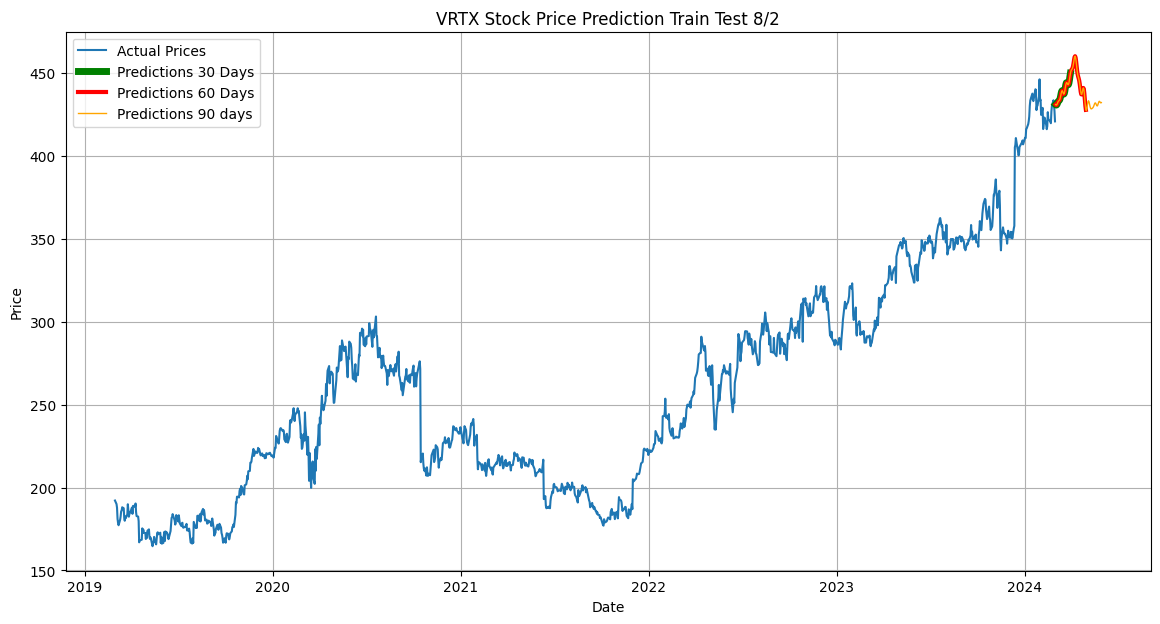

In [9]:
import matplotlib.pyplot as plt
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(original_dates, data['Adj Close'], label='Actual Prices')
plt.plot(future_df90['Date'].iloc[:30], future_df90['Predicted Price'].iloc[:30], label='Predictions 30 Days', color='green', linestyle='-', linewidth=5)
plt.plot(future_df90['Date'].iloc[:60], future_df90['Predicted Price'].iloc[:60], label='Predictions 60 Days', color='red', linestyle='-', linewidth=3)
plt.plot(future_df90['Date'], future_df90['Predicted Price'], label='Predictions 90 days', color='orange', linestyle='-', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('VRTX Stock Price Prediction Train Test 8/2')
plt.legend()
plt.grid(True)
plt.show()

# **Train Test 7/3**

**Predict next 30 days**

In [29]:
max_prediction_length = 30

train_data_30, test_data_30, train_size_30 = prepare_data(data, 0.7, max_encoder_length)
best_model_30, test_dataloader_30, training30 = train_nbeats_model(train_data_30, test_data_30, max_prediction_length, train_size_30, max_encoder_length)

evaluation_df30 = evaluate_model(best_model_30, test_data_30 ,test_dataloader_30, max_prediction_length, train_size_30)
print(evaluation_df30)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved duri

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:389: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


RMSE on test set: 7.815432832410604
MAE on test set: 6.260093994140628
MAPE on test set: 2.1760821468460234
         Date  Predicted Price  True Price
0  2022-08-30       278.064026      281.36
1  2022-08-31       277.564026      281.76
2  2022-09-01       277.839142      290.20
3  2022-09-02       277.810638      281.04
4  2022-09-03       276.759827      280.58
5  2022-09-04       274.866577      280.11
6  2022-09-05       273.077576      279.64
7  2022-09-06       272.416412      279.18
8  2022-09-07       273.251251      284.44
9  2022-09-08       275.055786      288.99
10 2022-09-09       276.823395      292.11
11 2022-09-10       277.810608      292.57
12 2022-09-11       278.049530      293.02
13 2022-09-12       278.252808      293.48
14 2022-09-13       279.196381      280.67
15 2022-09-14       281.055634      284.86
16 2022-09-15       283.203461      287.67
17 2022-09-16       284.626495      289.71
18 2022-09-17       284.652161      288.19
19 2022-09-18       283.443878  

In [30]:
future_df30 = predict_nbeats_model(best_model_30, training30, data, max_prediction_length)
print(future_df30)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


         Date  Predicted Price
0  2024-03-01       432.145844
1  2024-03-02       433.656128
2  2024-03-03       434.726379
3  2024-03-04       435.541718
4  2024-03-05       436.385803
5  2024-03-06       437.480499
6  2024-03-07       438.826447
7  2024-03-08       440.159821
8  2024-03-09       441.073944
9  2024-03-10       441.243988
10 2024-03-11       440.612518
11 2024-03-12       439.415924
12 2024-03-13       438.038696
13 2024-03-14       436.803894
14 2024-03-15       435.846375
15 2024-03-16       435.145538
16 2024-03-17       434.666992
17 2024-03-18       434.479858
18 2024-03-19       434.744995
19 2024-03-20       435.586487
20 2024-03-21       436.968903
21 2024-03-22       438.708618
22 2024-03-23       440.636566
23 2024-03-24       442.781952
24 2024-03-25       445.392639
25 2024-03-26       448.707977
26 2024-03-27       452.600098
27 2024-03-28       456.350525
28 2024-03-29       458.799438
29 2024-03-30       458.880402


**Predict for next 60 days**

In [32]:
max_prediction_length = 60

train_data_60, test_data_60, train_size_60 = prepare_data(data, 0.7, max_encoder_length)
best_model_60, test_dataloader_60, training60 = train_nbeats_model(train_data_60, test_data_60, max_prediction_length, train_size_60, max_encoder_length)

evaluation_df60 = evaluate_model(best_model_60, test_data_60 ,test_dataloader_60, max_prediction_length, train_size_60)
print(evaluation_df60)
future_df60 = predict_nbeats_model(best_model_60, training60, data, max_prediction_length)
print(future_df60)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved duri

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:389: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU ava

RMSE on test set: 23.838836194210167
MAE on test set: 21.12005342610677
MAPE on test set: 7.150103038541728
         Date  Predicted Price  True Price
0  2022-08-30       286.476379      281.36
1  2022-08-31       286.322754      281.76
2  2022-09-01       284.546783      290.20
3  2022-09-02       281.489960      281.04
4  2022-09-03       277.837006      280.58
5  2022-09-04       274.298126      280.11
6  2022-09-05       271.409912      279.64
7  2022-09-06       269.506012      279.18
8  2022-09-07       268.763153      284.44
9  2022-09-08       269.199219      288.99
10 2022-09-09       270.596619      292.11
11 2022-09-10       272.450378      292.57
12 2022-09-11       274.072632      293.02
13 2022-09-12       274.878082      293.48
14 2022-09-13       274.704590      280.67
15 2022-09-14       273.937897      284.86
16 2022-09-15       273.303040      287.67
17 2022-09-16       273.407623      289.71
18 2022-09-17       274.323975      288.19
19 2022-09-18       275.502960  

**Predict for next 90 days**

In [10]:
max_prediction_length = 90

train_data_90, test_data_90, train_size_90 = prepare_data(data, 0.7, max_encoder_length)
best_model_90, test_dataloader_90, training90 = train_nbeats_model(train_data_90, test_data_90, max_prediction_length, train_size_90, max_encoder_length)

evaluation_df90 = evaluate_model(best_model_90, test_data_90 ,test_dataloader_90, max_prediction_length, train_size_90)
print(evaluation_df90)
future_df90 = predict_nbeats_model(best_model_90, training90, data, max_prediction_length)
print(future_df90.head(90))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved duri

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:389: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: GPU available: False, u

RMSE on test set: 37.353960175899715
MAE on test set: 31.828227471245654
MAPE on test set: 10.457320942047303
         Date  Predicted Price  True Price
0  2022-08-30       279.261963      281.36
1  2022-08-31       279.758972      281.76
2  2022-09-01       281.039673      290.20
3  2022-09-02       282.116608      281.04
4  2022-09-03       282.322235      280.58
..        ...              ...         ...
85 2022-11-23       257.788422      316.16
86 2022-11-24       257.807037      314.57
87 2022-11-25       256.888855      312.98
88 2022-11-26       256.420746      313.75
89 2022-11-27       257.815155      314.53

[90 rows x 3 columns]
         Date  Predicted Price
0  2024-03-01       428.468872
1  2024-03-02       429.855133
2  2024-03-03       431.951263
3  2024-03-04       434.233459
4  2024-03-05       436.080048
..        ...              ...
85 2024-05-25       430.988007
86 2024-05-26       434.804993
87 2024-05-27       438.100189
88 2024-05-28       438.894165
89 2024-05

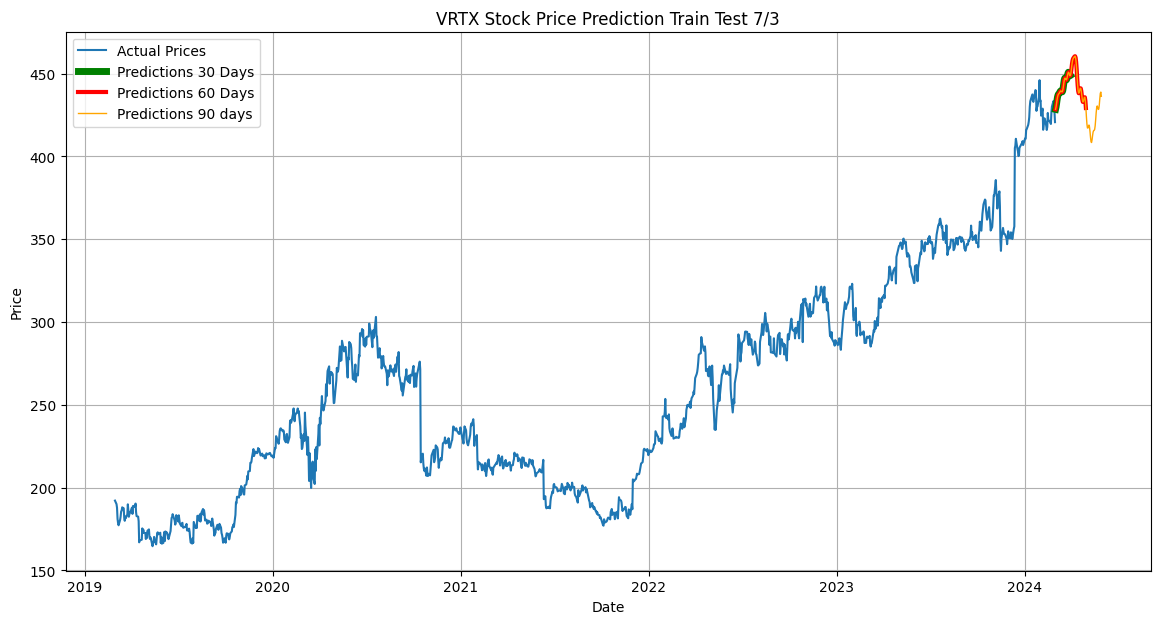

In [11]:
import matplotlib.pyplot as plt
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(original_dates, data['Adj Close'], label='Actual Prices')
plt.plot(future_df90['Date'].iloc[:30], future_df90['Predicted Price'].iloc[:30], label='Predictions 30 Days', color='green', linestyle='-', linewidth=5)
plt.plot(future_df90['Date'].iloc[:60], future_df90['Predicted Price'].iloc[:60], label='Predictions 60 Days', color='red', linestyle='-', linewidth=3)
plt.plot(future_df90['Date'], future_df90['Predicted Price'], label='Predictions 90 days', color='orange', linestyle='-', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('VRTX Stock Price Prediction Train Test 7/3')
plt.legend()
plt.grid(True)
plt.show()

# **Train Test 6/4**

**Predict next 30 days**

In [35]:
max_prediction_length = 30

train_data_30, test_data_30, train_size_30 = prepare_data(data, 0.6, max_encoder_length)
best_model_30, test_dataloader_30, training30 = train_nbeats_model(train_data_30, test_data_30, max_prediction_length, train_size_30, max_encoder_length)

evaluation_df30 = evaluate_model(best_model_30, test_data_30 ,test_dataloader_30, max_prediction_length, train_size_30)
print(evaluation_df30)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved duri

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:389: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


RMSE on test set: 4.061703156479429
MAE on test set: 3.220757100423175
MAPE on test set: 1.3258505138834258
         Date  Predicted Price  True Price
0  2022-03-01       235.092010      230.69
1  2022-03-02       236.167770      234.11
2  2022-03-03       237.336914      235.69
3  2022-03-04       238.581039      238.66
4  2022-03-05       239.848190      237.62
5  2022-03-06       241.038925      236.58
6  2022-03-07       242.053406      235.54
7  2022-03-08       242.868912      238.71
8  2022-03-09       243.578323      239.24
9  2022-03-10       244.340805      241.93
10 2022-03-11       245.266357      236.48
11 2022-03-12       246.317612      238.21
12 2022-03-13       247.312958      239.95
13 2022-03-14       248.044113      241.68
14 2022-03-15       248.432312      246.99
15 2022-03-16       248.607391      248.52
16 2022-03-17       248.841476      250.00
17 2022-03-18       249.372833      249.08
18 2022-03-19       250.239868      249.47
19 2022-03-20       251.245148  

In [36]:
future_df30 = predict_nbeats_model(best_model_30, training30, data, max_prediction_length)
print(future_df30)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


         Date  Predicted Price
0  2024-03-01       437.038391
1  2024-03-02       438.448120
2  2024-03-03       439.626709
3  2024-03-04       440.916168
4  2024-03-05       442.670074
5  2024-03-06       445.077515
6  2024-03-07       448.050018
7  2024-03-08       451.244263
8  2024-03-09       454.215546
9  2024-03-10       456.613098
10 2024-03-11       458.306763
11 2024-03-12       459.377930
12 2024-03-13       460.002014
13 2024-03-14       460.312347
14 2024-03-15       460.337280
15 2024-03-16       460.036835
16 2024-03-17       459.392822
17 2024-03-18       458.473053
18 2024-03-19       457.425812
19 2024-03-20       456.423004
20 2024-03-21       455.612152
21 2024-03-22       455.118591
22 2024-03-23       455.080566
23 2024-03-24       455.651886
24 2024-03-25       456.922485
25 2024-03-26       458.777222
26 2024-03-27       460.791748
27 2024-03-28       462.276611
28 2024-03-29       462.504547
29 2024-03-30       461.032959


**Predict for next 60 days**

In [37]:
max_prediction_length = 60

train_data_60, test_data_60, train_size_60 = prepare_data(data, 0.6, max_encoder_length)
best_model_60, test_dataloader_60, training60 = train_nbeats_model(train_data_60, test_data_60, max_prediction_length, train_size_60, max_encoder_length)

evaluation_df60 = evaluate_model(best_model_60, test_data_60 ,test_dataloader_60, max_prediction_length, train_size_60)
print(evaluation_df60)
future_df60 = predict_nbeats_model(best_model_60, training60, data, max_prediction_length)
print(future_df60)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved duri

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:389: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: GPU available: False, u

RMSE on test set: 23.048786125866965
MAE on test set: 17.13821287027995
MAPE on test set: 6.235639156465344
         Date  Predicted Price  True Price
0  2022-03-01       234.285202      230.69
1  2022-03-02       235.636810      234.11
2  2022-03-03       236.880157      235.69
3  2022-03-04       237.775482      238.66
4  2022-03-05       238.385742      237.62
5  2022-03-06       238.994827      236.58
6  2022-03-07       239.858582      235.54
7  2022-03-08       240.980225      238.71
8  2022-03-09       242.085754      239.24
9  2022-03-10       242.824661      241.93
10 2022-03-11       243.050949      236.48
11 2022-03-12       242.973297      238.21
12 2022-03-13       243.055176      239.95
13 2022-03-14       243.725220      241.68
14 2022-03-15       245.096207      246.99
15 2022-03-16       246.887085      248.52
16 2022-03-17       248.600433      250.00
17 2022-03-18       249.829834      249.08
18 2022-03-19       250.485703      249.47
19 2022-03-20       250.791412  

In [12]:
max_prediction_length = 90

train_data_90, test_data_90, train_size_90 = prepare_data(data, 0.6, max_encoder_length)
best_model_90, test_dataloader_90, training90 = train_nbeats_model(train_data_90, test_data_90, max_prediction_length, train_size_90, max_encoder_length)

evaluation_df90 = evaluate_model(best_model_90, test_data_90 ,test_dataloader_90, max_prediction_length, train_size_90)
print(evaluation_df90)



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved duri

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:389: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


RMSE on test set: 22.010690477976578
MAE on test set: 17.492591166178386
MAPE on test set: 6.619627438174873
         Date  Predicted Price  True Price
0  2022-03-01       234.531342      230.69
1  2022-03-02       237.170624      234.11
2  2022-03-03       239.699265      235.69
3  2022-03-04       241.956100      238.66
4  2022-03-05       243.803238      237.62
..        ...              ...         ...
85 2022-05-25       285.599945      270.84
86 2022-05-26       285.559723      269.65
87 2022-05-27       286.678497      273.73
88 2022-05-28       287.241882      272.46
89 2022-05-29       284.399200      271.19

[90 rows x 3 columns]


In [13]:
future_df90 = predict_nbeats_model(best_model_90, training90, data, max_prediction_length)
print(future_df90)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


         Date  Predicted Price
0  2024-03-01       440.006775
1  2024-03-02       439.755829
2  2024-03-03       438.961090
3  2024-03-04       438.230530
4  2024-03-05       438.190063
..        ...              ...
85 2024-05-25       436.423035
86 2024-05-26       436.508728
87 2024-05-27       436.906097
88 2024-05-28       437.382446
89 2024-05-29       437.428619

[90 rows x 2 columns]


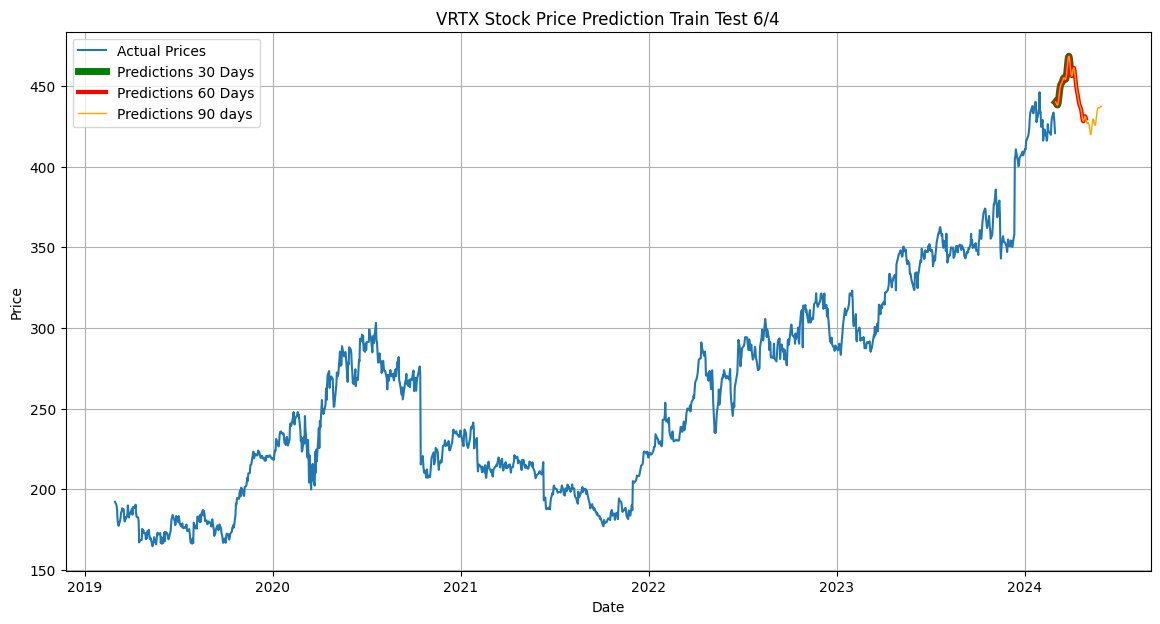

In [14]:
import matplotlib.pyplot as plt
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(original_dates, data['Adj Close'], label='Actual Prices')
plt.plot(future_df90['Date'].iloc[:30], future_df90['Predicted Price'].iloc[:30], label='Predictions 30 Days', color='green', linestyle='-', linewidth=5)
plt.plot(future_df90['Date'].iloc[:60], future_df90['Predicted Price'].iloc[:60], label='Predictions 60 Days', color='red', linestyle='-', linewidth=3)
plt.plot(future_df90['Date'], future_df90['Predicted Price'], label='Predictions 90 days', color='orange', linestyle='-', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('VRTX Stock Price Prediction Train Test 6/4')
plt.legend()
plt.grid(True)
plt.show()